# 4장 - 유용한 선형회귀
 
 
## 4.1 선형회귀의 필요성
* 회귀분석은 인과추론의 핵심이자 가장 많이 사용되는 방법론
* 대부분의 패널데이터 방법론, 머신러닝 방법, 도구변수의 활용, 불연속 설계 등 응용 방법론의 주요 구성 요소
 
### 4.1.1 모델이 필요한 이유
* 은행에서 대출 금액이나 신용카드 한도가 채무불이행률에 미치는 영향을 알아보는 예제
    * 실제 데이터에서는 신용한도와 채무불이행률 사이에 음의 상관관계가 있음
    * 이는 은행과 대출 회사에서 심사 모델에 따라 채무불이행 가능성이 낮은 고객에게 더 높은 신용 한도를 설정하기 때문이다. -> 교란편향으로 인한 음의 상관관계 발생
* 앞서 봤던 조건부 독립성 가정이 만족되면 인과효과를 식별할 수 있겠지만, 조건부를 설정할 변수가 연속형이거나 변수의 수가 많을수록 차원의 저주에 걸릴 수 있다.
* 이를 해결하기 위해 잠재적 결과를 선형회귀 같은 방식으로 모델링할 수 있다 가정하고, X로 정의된 각각의 셀을 내삽+외삽 하는 것이다.


In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf
import matplotlib
from cycler import cycler

default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

gr.set_default_format("png");

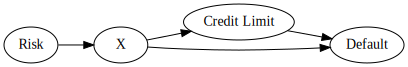

In [4]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Risk", "X")
g_risk.edge("X", "Credit Limit")
g_risk.edge("X", "Default")
g_risk.edge("Credit Limit", "Default")

g_risk

### 4.1.2 A/B 테스트와 회귀분석
* 온라인 스트리밍 기업에서 추천 시스템을 개선하는 상황을 가정해보자
    * 새로운 추천 시스템이 스트리밍 서비스의 시청 시간을 늘릴 수 있는지를 시험해보고자 할 때 관련된 수집 데이터는 아래와 같다.
* A/B 테스트 결과를 회귀분석으로 해석하면 필요한 추론 통계량 (표준오차, 신뢰구간)을 바로 구할 수 있다.
* 아래 예제의 회귀 모형은 아래와 같다.
    * $WahtchTime_i = \beta_0 + \beta_{1}challenger_{i}+e_i$
    * 새로운 버전의 효과는 $\beta_{1}$의 추정값인 $\hat{\beta_{1}}$ 이 된다.

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/rec_ab_test.csv")
data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


In [6]:
import statsmodels.formula.api as smf

result = smf.ols('watch_time ~ C(recommender)', data=data).fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


* 기존 버전의 추천 시스템을 사용했을 경우 절편항에 해당하는 2.04 시간 평균적으로 스트리밍을 이용한다고 할 수 있다.
* 0.14 가 새로운 버전 사용에 따른 시청 시간 증가 효과라 할 수 있다. 하지만 이는 통계적으로 유의하지 않다.

In [7]:
(data
 .groupby("recommender")
 ["watch_time"]
 .mean())

recommender
benchmark     2.049064
challenger    2.191750
Name: watch_time, dtype: float64

### 4.1.3 회귀분석을 통한 보정
* 다시 신용 한도와 채무불이행률 간의 관계를 회귀 모형으로 적용할 때 회귀 계수로 얻어진 값은 신용한도가 1달러 증가했을 때 채무불이행률이 얼마나 변할 것인지에 대한 기댓값을 나타낸다.
* 교란 변수를 처리하기 위해서는 회귀분석 모형에 단순히 교란요인들을 추가만 하면 된다. (OLS 추정)
    * $Default_i = \beta_0 + \beta_{1}line_{i} + \theta_{}X_{i}+ e_i$
    * $\beta_1$은 신용 한도에 대한 채무불이행률 기댓값의 편도함수라고 볼 수 있다.
    * 직관적으로 모델의 다른 변수들이 고정된 상태에서 신용 한도를 조금 늘렸을 때 채무불이행률이 얼마나 변할지에 대한 기댓값이다.

In [8]:
risk_data = pd.read_csv("./data/risk_data.csv")

risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


In [9]:
model = smf.ols('default ~ credit_limit', data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


Text(0.5, 1.0, 'Default Rate by Credit Limit')

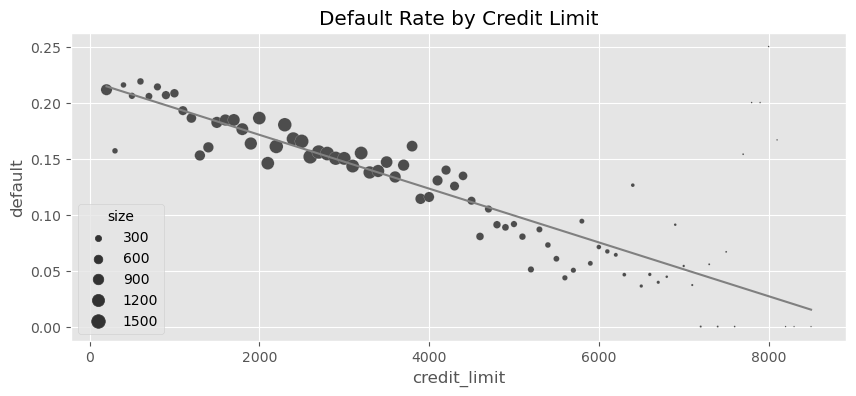

In [10]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index()
          .assign(prediction = lambda d: model.predict(d)))

plt.figure(figsize=(10,4))

sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit"], plt_df["prediction"], color="C1")
plt.title("Default Rate by Credit Limit")


In [11]:
risk_data.groupby(["credit_score1", "credit_score2"]).size().head()

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

In [12]:
formula = 'default ~ credit_limit + wage+credit_score1+credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


* 프리슈 워 로벨 정리 (FWL) 를 통해 편향 제거 단계와 영향 추정 단계를 분리할 수 있다. 

## 4.2 회귀분석 이론
* 매개변수 벡터를 $\beta^{*}$ 라 할 때 아래와 같이 정의할 수 있다.
    * $\beta^{*} = \underset{\beta}{argmin}E[{(Y_i - X_i^{`}\beta)}^2]$
* 선형회귀분석은 평균제곱오차를 최소화하는 매개변수를 찾는다. 이를 미분하고 그 결과를 0 으로 두면 선형 해는 아래와 같다.
    * $\beta^{*} = E{[X^{`}X]}^{-1}E[X^{`}Y]$

In [13]:
X_cols = ["credit_limit", "wage", "credit_score1", "credit_score2"]
X = risk_data[X_cols].assign(intercep=1)
y = risk_data["default"]

def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([ 3.06252773e-06, -8.82159125e-05, -4.17472814e-05, -3.03928359e-04,
        4.03661277e-01])

### 4.2.1 단순선형회귀
* 인과추론에서는 변수 T가 결과 Y에 미치는 인과효과를 추정하려는 경우가 많다.
* 단일 설명변수 T를 사용할 때 관련된 매개변수는 아래와 같다.
    * $\hat{\tau} = \frac{Cov(Y_i, T_i)}{Var(T_i)} = \frac{E[(T_i-\bar{T})(Y_i - \bar{Y})]}{E[(T_i - \bar{T})^2]}$
* 회귀분석은 처치와 결과가 어떻게 함꼐 움직이는지(분자의 공분산) 를 파악하고 이를 처치 대상에 따라 조정한다.

### 4.2.2 다중선형회귀
* 다중선형회귀의 경우 단순선형회귀분석을 확장하기만 하면 된다. 다른 변수는 보조적인 변수들이고 T와 관련된 $\tau$ 를 추정하는 것으로 생각하면 아래와 같이 정리할 수 있다.
    * $\hat{\tau} = \frac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})}$
    * $\tilde{T_i}$ 는 $T_i$ 를 모든 공변량 $X_{1i} + ...  + X_{ki}$ 에 대해 회귀한 잔차이다.
    * 다시 말해, 다중회귀분석의 회귀계수는 모델의 다른 변수들의 효과를 고려한 후 얻은 동일 설명변수의 이변량 계수라는 의미이다.
* 직관적으로 보면, 다른 변수를 사용해 T를 예측할 수 있다면 T는 무작위가 아니다. 그러나 모든 교란 요인 X를 통제하면 T를 무작위로 보이게 할 수 있다.
    * 이를 위해 선형회구분석을 사용해 교란 요인에서 T를 예측한 다음, T에서 해당 회귀에 대한 잔차인 $\tilde{T}$ 를 뺴주면 된다.

## 4.3 프리슈-워-로벨 정리와 직교화
* FWL 스타일의 직교화는 가장 먼저 사용할 수 있는 편향 제거(debiasing) 기법이다.
* FWL 정리에 따르면 다중선형회귀분석은 한 번에 추정하거나 세 단계에 걸쳐 추정할 수 있다.
* 먼저 아래처럼 Y~T,X1,X2,... 로 회귀할 수 있다.
* FWL 정리에 따라 추정 과정을 다음과 같이 세 단계로 나눌 수 있다.
    1. 편향 제거 단계 : 처치 T를 교란 요인 X에 회귀해 처지 잔차를 구한다.
    2. 잡음 제거 단계 : 결과 Y를 교란 요인 X에 회귀해 결과 잔차를 구한다.
    3. 결과 모델 단계 : 결과 잔차를 처치 잔차에 대해 회귀해 T가 Y에 미치는 인과효과 추정값은 구한다.

In [14]:
formula = 'default ~ credit_limit + wage+credit_score1+credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


### 4.3.1 편향 제거 단계
* FWL 정리에 따르면, 교란 요인으로부터 처치인 신용 한도를 예측하는 회귀 모델을 적합시켜 데이터의 편향을 제거할 수 있다. 이 때 구해진 잔차는 편향 제거 모델에 사용된 변수와는 상관관계가 없는 버전의 처치로 간주할 수 있다. (예측값을 새성한 변수와 직교하기 때문)

Text(0.5, 1.0, 'Default Rate by Credit Limit')

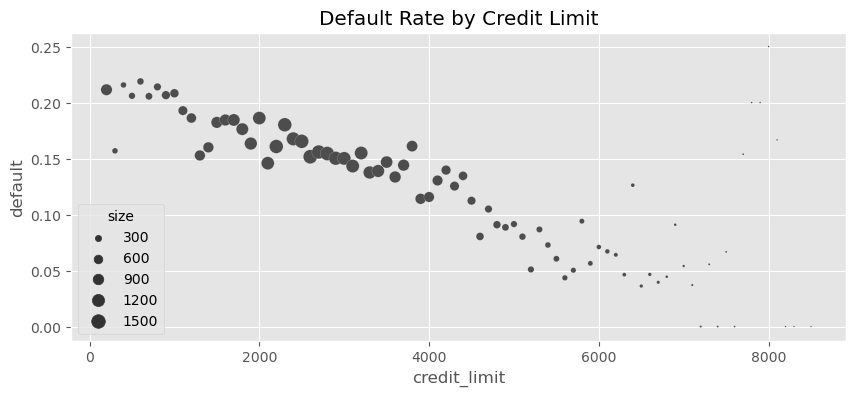

In [15]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))


plt.title("Default Rate by Credit Limit")


In [16]:
debiasing_model = smf.ols(
    'credit_limit ~ wage + credit_score1  + credit_score2',
    data=risk_data
).fit()

risk_data_deb = risk_data.assign(
    # for visualization, avg(T) is added to the residuals
    credit_limit_res=(debiasing_model.resid 
                      + risk_data["credit_limit"].mean())
)

In [17]:
model_w_deb_data = smf.ols('default ~ credit_limit_res',
                           data=risk_data_deb).fit()

model_w_deb_data.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.001,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.56e-06,1.957,0.050,-4.29e-09,6.13e-06


* full model 과 차이가 있다면 p값이 약간 높다는 점이다. 이는 분산 감소를 담당하는 잡음 제거 단계를 거치지 않았기 때문이다. 잔차와 결과 변수 간의 관계를 시각화 하면 아래와 같다.

Text(0.5, 1.0, 'Default Rate by Debiased Credit Limit')

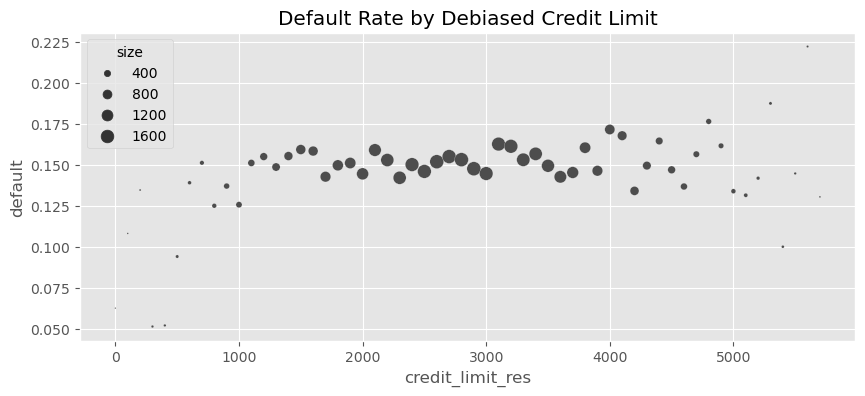

In [18]:
plt_df = (risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default": "mean", "size":sum})
          .query("size>30")
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))

plt.title("Default Rate by Debiased Credit Limit")


### 4.3.2 잡음 제거 단계
* 잡음을 제거한다고 처치 효과의 추정값이 바뀌지는 않지만 분산을 줄일 수 있는 효과를 가진다.
* 이 단계에서는 결과를 처치가 아닌 공변량 X에 대해 회귀한다.

In [19]:
denoising_model = smf.ols(
    'default ~ wage + credit_score1  + credit_score2',
    data=risk_data_deb
).fit()

risk_data_denoise = risk_data_deb.assign(
    default_res=denoising_model.resid + risk_data_deb["default"].mean()
)

### 4.3.3 회귀 추정량의 표준오차
* 추정한 회귀계수의 표준오차 공식은 아래와 같다.
    * $SE(\hat{\beta}) = \frac{\sigma(\hat{\epsilon})}{\sigma(\tilde{T})\sqrt{n-DF}}$
* 분자는 결과를 잘 예측할수록 잔차가 작아지므로 추정값의 분산이 낮아진다.
    * 처치가 결과를 많이 설명하면 추정값의 표준오차도 작아진다.
* 오차는 (잔차화된) 처치의 분산에 반비례한다. 

In [20]:
model_se = smf.ols(
    'default ~ wage + credit_score1  + credit_score2',
    data=risk_data
).fit()

print("SE regression:", model_se.bse["wage"])


model_wage_aux = smf.ols(
    'wage ~ credit_score1 + credit_score2',
    data=risk_data
).fit()

# subtract the degrees of freedom - 4 model parameters - from N.
se_formula = (np.std(model_se.resid)
              /(np.std(model_wage_aux.resid)*np.sqrt(len(risk_data)-4)))

print("SE formula:   ", se_formula)

SE regression: 5.364242347548209e-06
SE formula:    5.364242347548201e-06


### 4.3.4 최종 결과 모델
* 마지막으로 두 잔차를 이용해 회귀를 진행하면 full model 에서 얻었던 결과와 동일한 결과를 얻게 된다.

In [21]:
model_w_orthogonal = smf.ols('default_res ~ credit_limit_res',
                             data=risk_data_denoise).fit()

model_w_orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.458,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.54e-06,1.987,0.047,4.17e-08,6.08e-06


Text(0.5, 1.0, 'Denoised Default Rate by Debiased Credit Limit')

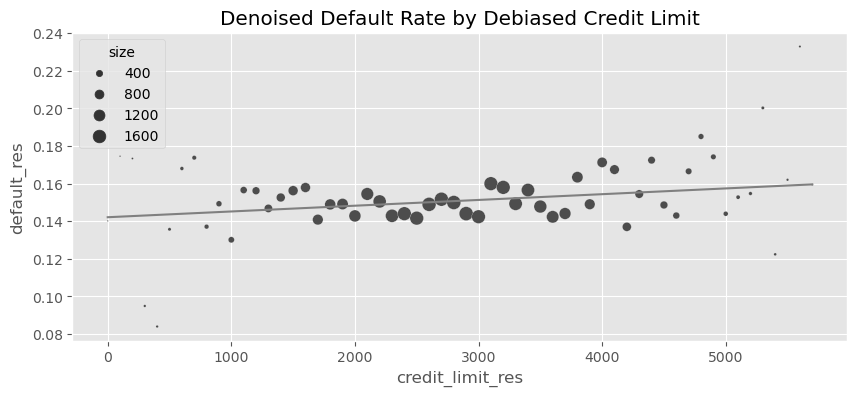

In [22]:
plt_df = (risk_data_denoise
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default_res": "mean", "size":sum})
          .query("size>30")
          .reset_index()
          .assign(prediction = lambda d: model_w_orthogonal.predict(d)))

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default_res",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit_res"], plt_df["prediction"], c="C1")

plt.title("Denoised Default Rate by Debiased Credit Limit")



### 4.3.5 FWL 정리 요약

## 4.4 결과 모델으로서의 회귀분석
* 회귀분석은 잠재적 결과를 대체하는 방법으로도 볼 수 있다.
* 대조군 (T=0) 에서 X에 대한 Y의 회귀 분석이 $E[Y_0|X]$를 아주 잘 근사한다면, 해당 모델을 이용해 ATT를 추정할 수 있다.
    * $ATT = \frac{1}{N}\sum{I(T_i=1)(Y_i- \hat{\mu_0}(X_i))}$
* 동일하게 실험군에서도 X에 대한 Y의 회귀분석이 잘 모델링된다면, 대조군에서의 평균 효과를 추정할 수 있다.
    * $ATE = \frac{1}{N}\sum{\hat{\mu_1}(X_i) - \hat{\mu_0}(X_i)}$
* $E[T|X]$를 정확하게 추정하여 직교화할 수 있거나 잠재적 결과 $E[Y_t|X]$를 정확하게 추정할 수 있다느 사실은 회귀분석이 이중 강건하다는 특성을 나타낸다.

## 4.5 양수성과 외삽
* 회귀분석은 잠재적 결과를 모수적으로 모델링하므로 데이터의 처치 범위 외의 범위에 대해서도 외삽을 할 수 있다. 단, 외삽은 데이터에 따라 합리적일수도 있고 그렇지 않을수도 있다.
* 양수성 가정이 충족되지 않는 영역, 즉 특정 처치를 전혀 받지 않을 확률이 있는 범위에서 처치 효과는 정확히 알 수 없다. 이 범위 내에서 외삽을 신뢰할 수도 있지만 이에 따른 위험도 감수해야 한다.

Text(0.5, 1.0, 'Dataset 2')

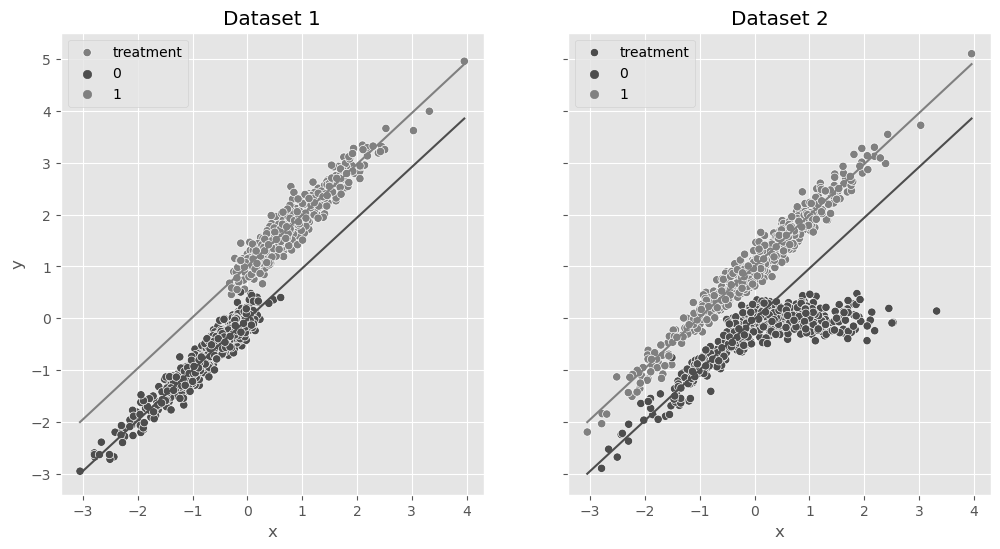

In [23]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.2, n) > 0

y0 = x 
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.scatterplot(data=df_no_pos, x="x", y="y", hue="t", ax=ax1, label="treatment")

m0 = smf.ols("y~x", data=df_no_pos.query(f"t==0")).fit()
m1 = smf.ols("y~x", data=df_no_pos.query(f"t==1")).fit()

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_no_pos)), x="x", y="pred", color=f"C0", ax=ax1)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_no_pos)), x="x", y="pred", color=f"C1", ax=ax1);
ax1.set_title("Dataset 1")

np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.binomial(1, 0.5, size=n)

y0 = x * (x<0) + (x>0)*0
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

sns.scatterplot(data=df_pos, x="x", hue="t", y="y", ax=ax2, label="treatment")

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_pos)), x="x", y="pred", color=f"C0", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_pos)), x="x", y="pred", color=f"C1", ax=ax2)
ax2.set_title("Dataset 2")



## 4.6 선형회귀에서의 비선형성
* 아래의 예시에서 신용 한도가 소비에 미치는 영향을 파악하려면 임금을 통제해야 한다. 이 떄 임금 수준에서 신용 한도별 소비 그래프를 그려보면 두 변수의 관계는 선형적이지 않다. (concavity)
* 문제는 인과추론 관점에서 신용 한도가 증가함에 따라 한도가 소비에 미치는 효과는 감소한다고 볼 수 있다.

In [24]:
spend_data = pd.read_csv("./data/spend_data.csv")

spend_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508


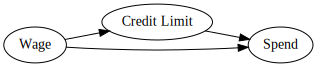

In [25]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Wage", "Credit Limit")
g_risk.edge("Wage", "Spend")
g_risk.edge("Credit Limit", "Spend")

g_risk

<Axes: xlabel='credit_limit', ylabel='spend'>

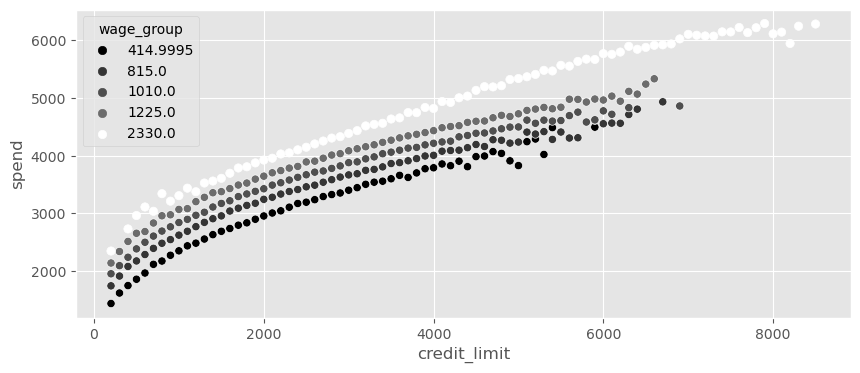

In [26]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                hue="wage_group",
                palette="gray")


### 4.6.1 처치 선형화
* 이 문제를 해결하려면, 먼저 처치를 결과와 선형 관계로 변환해야 한다. (관계가 concavity 를 보이면 로그 함수, 제곱근 함수 등 오목 함수를 적용해볼 수 있다.)
* 모델에 임금을 포함해 임금 수준이 소비에 미치는 영향의 편향되지 않는 추정값을 얻을 수 있다. (상향편향이 보정되는 것을 볼 수 있다.)

<Axes: xlabel='credit_limit_sqrt', ylabel='spend'>

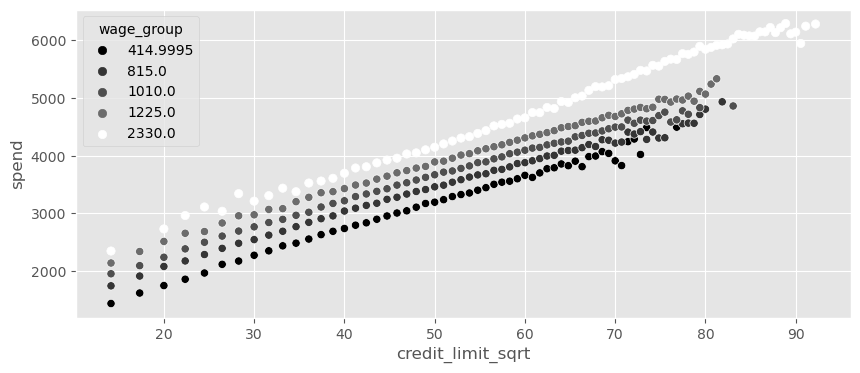

In [27]:
plt_df = (spend_data
          # apply the sqrt function to the treatment
          .assign(credit_limit_sqrt = np.sqrt(spend_data["credit_limit"]))
          # create 5 wage binds for better vizualization
          .assign(wage_group = pd.IntervalIndex(pd.qcut(spend_data["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit_sqrt"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit_sqrt",
                y="spend",
                palette="gray",
                hue="wage_group")


In [28]:
model_spend = smf.ols(
    'spend ~ np.sqrt(credit_limit)',data=spend_data
).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,493.0044,6.501,75.832,0.000,480.262,505.747
np.sqrt(credit_limit),63.2525,0.122,519.268,0.000,63.014,63.491


<Axes: xlabel='credit_limit', ylabel='spend'>

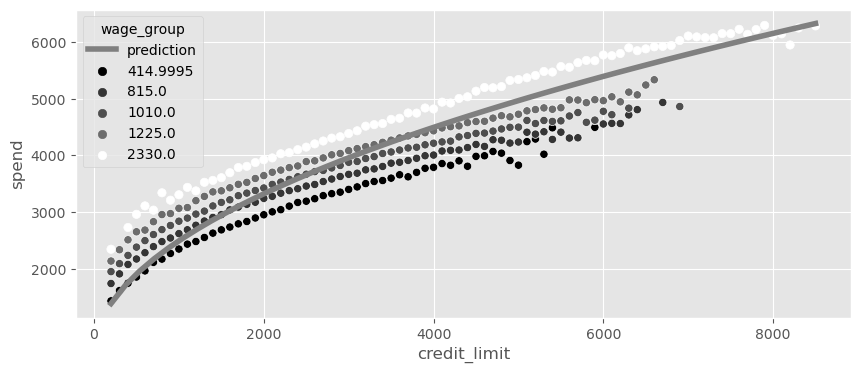

In [29]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index()
         )

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, model_spend.params[0] + model_spend.params[1]*np.sqrt(x), color="C1", label="prediction", lw=4)
plt.legend()
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")



In [30]:
model_spend = smf.ols('spend ~ np.sqrt(credit_limit)+wage',
                      data=spend_data).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,383.5002,2.746,139.662,0.000,378.118,388.882
np.sqrt(credit_limit),43.8504,0.065,672.633,0.000,43.723,43.978
wage,1.0459,0.002,481.875,0.000,1.042,1.050


### 4.6.2 비선형 FWL과 편향 제거
* 처치 선형화 단계 : T와 Y의 관계를 선형화화는 함수 F를 찾는다.
* 편향 제거 단계 : F(T)를 교란 요인 X에 회귀하고 처치 잔차를 구한다.
* 잡음 제거 단계 : 결과 Y를 교란 요인 X에 회귀하고 결과 잔차를 구한다.
* 결과 모델 단계 : 결과 잔차를 처치 잔차에 회귀해 인과효과 추정값을 구한다.

In [31]:
debias_spend_model = smf.ols(f'np.sqrt(credit_limit) ~ wage',
                             data=spend_data).fit()
denoise_spend_model = smf.ols(f'spend ~ wage', data=spend_data).fit()


credit_limit_sqrt_deb = (debias_spend_model.resid 
                         + np.sqrt(spend_data["credit_limit"]).mean())
spend_den = denoise_spend_model.resid + spend_data["spend"].mean()


spend_data_deb = (spend_data
                  .assign(credit_limit_sqrt_deb = credit_limit_sqrt_deb,
                          spend_den = spend_den))

final_model = smf.ols(f'spend_den ~ credit_limit_sqrt_deb',
                      data=spend_data_deb).fit()

final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1493.6990,3.435,434.818,0.000,1486.966,1500.432
credit_limit_sqrt_deb,43.8504,0.065,672.640,0.000,43.723,43.978


<Axes: xlabel='credit_limit', ylabel='spend'>

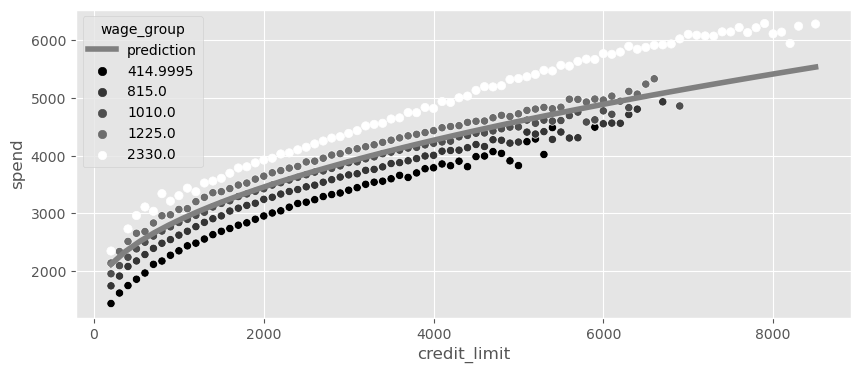

In [32]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, (final_model.params[0] 
             + final_model.params[1]*np.sqrt(x)),
         color="C1", label="prediction", lw=4)

plt.legend()

sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")


## 4.7 더미변수를 활용한 회귀분석
* 모델에 모든 교란 요인이 포함되는지를 판단하기는 매우 어려우므로 가능하면 RCT를 하는게 좋다. 하지만 대부분의 현실 문제에서 RCT를 적용하는데는 시간과 비용 문제가 발생하므로 한계가 있다.
### 4.7.1 조건부 무작위 실험
* 대안으로 쓸 수 있는 방법은 계층화 또는 조건부 무작이 실험이다. 
* 아래 예시에 적용하면, 모든 고객에게 동일한 확률 분포에서 무작위로 신용 한도를 설정하는 실험 대신, 공변량에 따라 서로 다른 분포에서 표본을 뽑아 여러 국소 실험을 설계하는 것이다.
    * 예시에선 credit_score1 이 신용 위험도의 대리변수이기 때문에 이를 이용해 고객 그룹을 생성할 수 있다. credit_score1이 낮은 고위험 그룹은 평균이 낮은 분포에서 신용한도를 추출해 무작위 배정을 하고, 높은 경우는 반대로 평균이 높은 분포에서 추출해 신용 한도를 무작위로 배정한다.
    * 그룹 수가 적을 수록 조건부 무작위 실험을 진행하기 더 쉬워진다. 처치분포가 서로 다른 여러 그룹을 결합하면 복잡해지므로 적은 수의 그룹을 유지하는 것이 좋다.
    * 그룹간 처치 분포가 많이 중첩될수록 분석이 용이하다. 이는 양수성 가정과 연관이 있고 중첩이 거의 없는 경우에는 외삽에 의한 위험을 크게 감수해야 할 수도 있다.

In [33]:
risk_data_rnd = pd.read_csv("./data/risk_data_rnd.csv")
risk_data_rnd.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default
0,890.0,11,16,1,490.0,500.0,400,5400.0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0


Text(0.5, 1.0, 'Conditional random experiment')

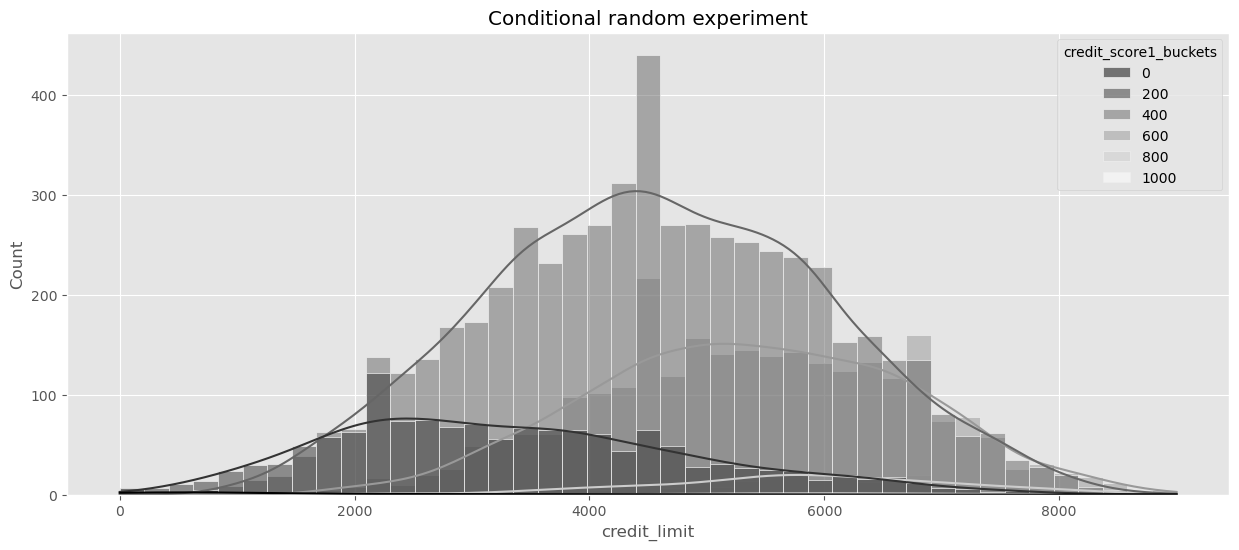

In [34]:
plt.figure(figsize=(15,6))
sns.histplot(data=risk_data_rnd,
             x="credit_limit",
             hue="credit_score1_buckets",
             kde=True,
             palette="gray");
plt.title("Conditional random experiment")

### 4.7.2 더미변수
* 그룹 자체를 통제하는 방법은 더미변수를 만드는 것이다.
    * $default_i = \beta_0 + \beta_{1}lines_i + \theta G_i + e_i$
* 더미변수 별 각 기울기는 각 그룹의 회귀에 대한 분산 가중평균이 된다. 

In [35]:
model = smf.ols("default ~ credit_limit", data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1369,0.009,15.081,0.000,0.119,0.155
credit_limit,-9.344e-06,1.85e-06,-5.048,0.000,-1.3e-05,-5.72e-06


In [36]:
pd.set_option('display.max_columns', 9)

In [37]:
risk_data_dummies = (risk_data_rnd
                     .join(pd.get_dummies(risk_data_rnd["credit_score1_buckets"],
                                          prefix="sb",
                                          drop_first=True)))
risk_data_dummies.head()

,wage,educ,exper,married,...,sb_400,sb_600,sb_800,sb_1000
0,890.0,11,16,1,...,True,False,False,False
1,670.0,11,7,1,...,False,False,False,False
2,1220.0,14,9,1,...,True,False,False,False
3,1210.0,15,8,1,...,False,True,False,False
4,900.0,16,1,1,...,False,False,False,False


In [38]:
model = smf.ols(
    "default ~ credit_limit + sb_200+sb_400+sb_600+sb_800+sb_1000",
    data=risk_data_dummies
).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
sb_200[T.True],-0.0559,0.057,-0.981,0.327,-0.168,0.056
sb_400[T.True],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
sb_600[T.True],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
sb_800[T.True],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
sb_1000[T.True],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


In [39]:
model = smf.ols("default ~ credit_limit + C(credit_score1_buckets)",
                data=risk_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
C(credit_score1_buckets)[T.200],-0.0559,0.057,-0.981,0.327,-0.168,0.056
C(credit_score1_buckets)[T.400],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
C(credit_score1_buckets)[T.600],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
C(credit_score1_buckets)[T.800],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
C(credit_score1_buckets)[T.1000],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


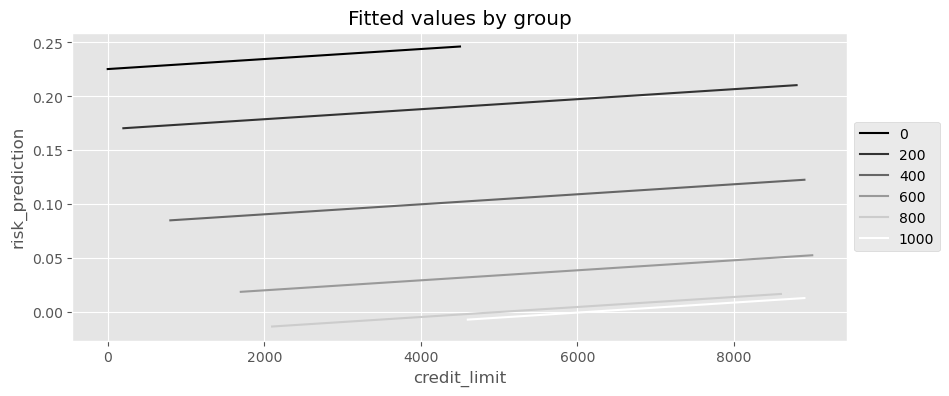

In [40]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets", palette = 'gray');
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


### 4.7.3 포화회귀모델
* 조건부 무작위 실험의 데이터를 그룹화하고 그룹별로 효과를 추정한다음, 각 그룹의 크기를 가중치 삼아 가중평균을 게산한다면 그룹별 평균 효과를 알 수 있다.
* 회귀분석에서도 똑같은 작업을 수행할 수 있고 이를 포화모델이라 한다.

In [41]:
def regress(df, t, y):
    return smf.ols(f"{y}~{t}", data=df).fit().params[t]

effect_by_group = (risk_data_rnd
                   .groupby("credit_score1_buckets")
                   .apply(regress, y="default", t="credit_limit"))
effect_by_group

credit_score1_buckets
0      -0.000071
200     0.000007
400     0.000005
600     0.000003
800     0.000002
1000    0.000000
dtype: float64

In [42]:
group_size = risk_data_rnd.groupby("credit_score1_buckets").size()
ate = (effect_by_group * group_size).sum() / group_size.sum()
ate

4.4904456287487265e-06

* 포화모델(saturated model)은 회귀분석에서 모든 가능한 설명변수와 그 상호작용을 포함하는 모델을 말한다. 모든 변수와의 상호작용항을 포함하기 때문에 과적합위험이 있지만 특정 그룹의 인과효과를 파악하는데 유용하다.

In [43]:
model = smf.ols("default ~ credit_limit * C(credit_score1_buckets)",
                data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3137,0.077,4.086,0.000,0.163,0.464
C(credit_score1_buckets)[T.200],-0.1521,0.079,-1.926,0.054,-0.307,0.003
C(credit_score1_buckets)[T.400],-0.2339,0.078,-3.005,0.003,-0.386,-0.081
C(credit_score1_buckets)[T.600],-0.2957,0.080,-3.690,0.000,-0.453,-0.139
C(credit_score1_buckets)[T.800],-0.3227,0.111,-2.919,0.004,-0.539,-0.106
C(credit_score1_buckets)[T.1000],-0.3137,0.428,-0.733,0.464,-1.153,0.525
credit_limit,-7.072e-05,4.45e-05,-1.588,0.112,-0.000,1.66e-05
credit_limit:C(credit_score1_buckets)[T.200],7.769e-05,4.48e-05,1.734,0.083,-1.01e-05,0.000
credit_limit:C(credit_score1_buckets)[T.400],7.565e-05,4.46e-05,1.696,0.090,-1.18e-05,0.000
credit_limit:C(credit_score1_buckets)[T.600],7.398e-05,4.47e-05,1.655,0.098,-1.37e-05,0.000


In [44]:
(model.params[model.params.index.str.contains("credit_limit:")]
 + model.params["credit_limit"]).round(9)

credit_limit:C(credit_score1_buckets)[T.200]     0.000007
credit_limit:C(credit_score1_buckets)[T.400]     0.000005
credit_limit:C(credit_score1_buckets)[T.600]     0.000003
credit_limit:C(credit_score1_buckets)[T.800]     0.000002
credit_limit:C(credit_score1_buckets)[T.1000]    0.000000
dtype: float64

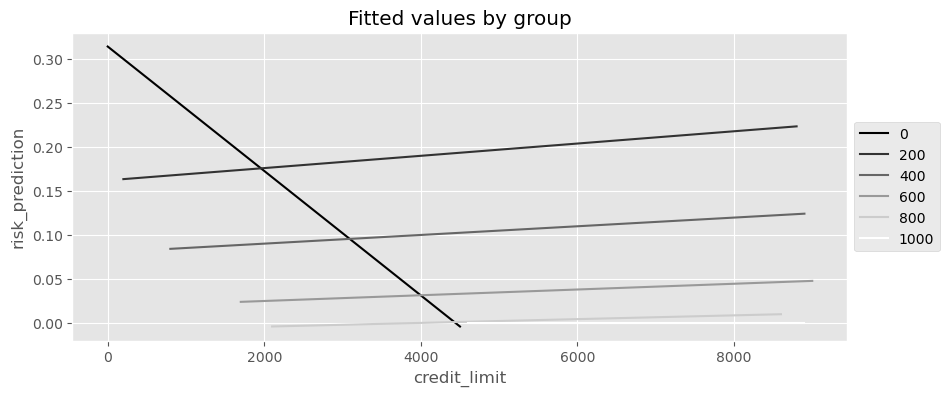

In [45]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets",  palette="gray");
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### 4.7.4 분산의 가중평균과 회귀분석
* 상호작용항 없이 모델을 실행하면 단일 효과, 즉 하나의 기울기 매개변수만 얻게 된다. 이 효과 추정값은 그룹별 효과를 추저하고 그룹 크기를 가중치로 사용한 평균값과 다르다. 즉, 회귀분석은 여러 그룹의 효과를 합친 것이지만 표본 크기를 기준으로 한 가중평균은 아니다.
* 아래 처럼 서로 다른 분포에서 다른 크기의 데이터를 생성해 그룹별 효과를 추정하고 그룹별 가중치로 ATE를 구했다고 하자.
* 그러나 그룹을 통제하면서 y~t 를 회귀하면 다른 결과가 도출된다. 이는 회귀 분석이 그룹 효과를 결합할 때 표본 크기 대신 그룹에서의 처치의 분산에 비례하는 가중치를 사용하기 때문이다.

In [46]:
np.random.seed(123)

# std(t)=1
t1 = np.random.normal(0, 1, size=1000)
df1 = pd.DataFrame(dict(
    t=t1,
    y=1*t1, # ATE of 1
    g=1,
))

# std(t)=2
t2 = np.random.normal(0, 2, size=500)
df2 = pd.DataFrame(dict(
    t=t2,
    y=2*t2, # ATE of 2
    g=2,
))

df = pd.concat([df1, df2])
df.head()

,t,y,g
0,-1.085631,-1.085631,1
1,0.997345,0.997345,1
2,0.282978,0.282978,1
3,-1.506295,-1.506295,1
4,-0.578600,-0.578600,1


In [47]:
effect_by_group = df.groupby("g").apply(regress, y="y", t="t")
ate = (effect_by_group *
       df.groupby("g").size()).sum() / df.groupby("g").size().sum()
ate

1.3333333333333324

In [57]:
model = smf.ols("y ~ t + C(g)", data=df).fit()
model.params

Intercept    0.024758
C(g)[T.2]    0.019860
t            1.625775
dtype: float64

### 4.7.5 평균 제거와 고정효과
* FWL 정리에서 편향 제거 단계는 공변량에서 처치를 에측하는 과정을 포함한다. 

In [47]:
model_deb = smf.ols("credit_limit ~ C(credit_score1_buckets)",
                    data=risk_data_rnd).fit()
model_deb.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1173.0769,278.994,4.205,0.000,626.193,1719.961
C(credit_score1_buckets)[T.200],2195.4337,281.554,7.798,0.000,1643.530,2747.337
C(credit_score1_buckets)[T.400],3402.3796,279.642,12.167,0.000,2854.224,3950.535
C(credit_score1_buckets)[T.600],4191.3235,280.345,14.951,0.000,3641.790,4740.857
C(credit_score1_buckets)[T.800],4639.5105,291.400,15.921,0.000,4068.309,5210.712
C(credit_score1_buckets)[T.1000],5006.9231,461.255,10.855,0.000,4102.771,5911.076


In [48]:
risk_data_rnd.groupby("credit_score1_buckets")["credit_limit"].mean()

credit_score1_buckets
0       1173.076923
200     3368.510638
400     4575.456498
600     5364.400448
800     5812.587413
1000    6180.000000
Name: credit_limit, dtype: float64

In [49]:
risk_data_fe = risk_data_rnd.assign(
    credit_limit_avg = lambda d: (d
                                  .groupby("credit_score1_buckets")
                                  ["credit_limit"].transform("mean"))
)

In [50]:
model = smf.ols("default ~ I(credit_limit-credit_limit_avg)",
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0935,0.003,32.121,0.000,0.088,0.099
I(credit_limit - credit_limit_avg),4.652e-06,2.05e-06,2.273,0.023,6.4e-07,8.66e-06


In [51]:
model = smf.ols("default ~ credit_limit + credit_limit_avg",
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4325,0.020,21.418,0.000,0.393,0.472
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.96e-07,8.61e-06
credit_limit_avg,-7.763e-05,4.75e-06,-16.334,0.000,-8.69e-05,-6.83e-05


In [2]:
import pandas as pd
pd.read_csv("./sh_card_weekly_ms.csv").to_csv('./sh_card_weekly_ms2.csv',encoding='utf-8')

## 4.8 누락 변수 편향
* 공통 원인(교란 원인; confounder)이 처치와 결과 간의 추정관계를 편향 시킬 수 있으므로 회귀모델에 이러한 요인들을 포함해 다뤄야 한다.
* 회귀 분석을 통해 누락 변수 편향 (omitted variable bias)은
    * 누락 변수가 포함된 전체 모델의 회귀 계수 더하기
    * (결과에 미치는 누락 변수의 효과) * (처치에 대한 누락 변수의 회귀 계수) 로 정의할 수 있다.
    * $frac{Cov(T,Y)}{Var(T)} = \tau + \beta_{omitted}\delta_{omitted}$
    

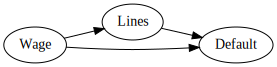

In [48]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("Lines", "Default")
g.edge("Wage", "Default"),
g.edge("Wage", "Lines")


g

In [49]:
short_model = smf.ols("default ~ credit_limit", data=risk_data).fit()
short_model.params["credit_limit"]

-2.4019619925968837e-05

In [50]:
long_model = smf.ols("default ~ credit_limit + wage",
                     data=risk_data).fit()

omitted_model = smf.ols("wage ~ credit_limit", data=risk_data).fit()

(long_model.params["credit_limit"] 
 + long_model.params["wage"]*omitted_model.params["credit_limit"])

-2.4019619925968864e-05

## 4.9 중립 통제변수
* 교란 요인 X 를 포함해 편향을 보정할 수 있음을 알아보았는데 X에 어떤 변수들을 포함시켜야할지 고려해야 한다.
* 그래프 구조에서 확인한 것 처럼 충돌부나 매개자는 선택편향을 유발할 수 있기 떄문에 포함시키지 않는 것이 좋다. 
* 추가로 통제 변수는 회귀분석 추정에서 편향에 영향을 미치지 않기 때문에 중립적이지만 분산에는 심각한 영향을 줄 수 있다.
* 아래의 DAG 에서 credit_score2 를 포함하게 되면
    * credit_limit(Lines) 의 추정값이 조금 더 커진다. 그리고 표준오차가 감소한다.
    * 즉, 추가 변수가 Y를 예측하고 선형회귀의 잡음 제거 단계에 기여했다 할 수 있다.

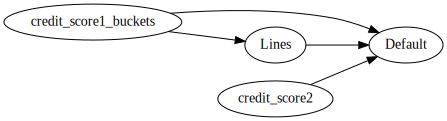

In [51]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets", "Default"),
g.edge("credit_score1_buckets", "Lines"),
g.edge("credit_score2", "Default"),
g.edge("Lines", "Default")

g

In [52]:
formula = "default~credit_limit+C(credit_score1_buckets)"
model = smf.ols(formula, data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
C(credit_score1_buckets)[T.200],-0.0559,0.057,-0.981,0.327,-0.168,0.056
C(credit_score1_buckets)[T.400],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
C(credit_score1_buckets)[T.600],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
C(credit_score1_buckets)[T.800],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
C(credit_score1_buckets)[T.1000],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


In [53]:
formula = "default~credit_limit+C(credit_score1_buckets)+credit_score2"
model = smf.ols(formula, data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5576,0.055,10.132,0.000,0.450,0.665
C(credit_score1_buckets)[T.200],-0.0387,0.055,-0.710,0.478,-0.146,0.068
C(credit_score1_buckets)[T.400],-0.1032,0.054,-1.898,0.058,-0.210,0.003
C(credit_score1_buckets)[T.600],-0.1410,0.055,-2.574,0.010,-0.248,-0.034
C(credit_score1_buckets)[T.800],-0.1161,0.057,-2.031,0.042,-0.228,-0.004
C(credit_score1_buckets)[T.1000],-0.0430,0.090,-0.479,0.632,-0.219,0.133
credit_limit,4.928e-06,1.93e-06,2.551,0.011,1.14e-06,8.71e-06
credit_score2,-0.0007,2.34e-05,-30.225,0.000,-0.001,-0.001


### 4.9.1 잡음 유발 통제변수
* 위의 DAG와는 다르게 교란 요인이 없는 상태를 가정해 추가 요인을 더하는 경우의 결과를 비교해보면 아래와 같다.
* 두 결과를 비교해보면, 추가 변수를 더하게 될 경우 처치 효과가 작아짐과 동시에 신뢰구간이 매우 넓어진 것을 볼 수 있다.

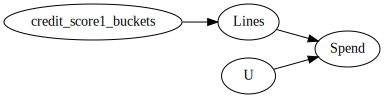

In [57]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("credit_score1_buckets", "Lines"),
g.edge("U", "Spend"),
g.edge("Lines", "Spend")

g

In [58]:
spend_data_rnd = pd.read_csv("data/spend_data_rnd.csv")

model = smf.ols("spend ~ np.sqrt(credit_limit)",
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2153.2154,218.600,9.850,0.000,1723.723,2582.708
np.sqrt(credit_limit),16.2915,2.988,5.452,0.000,10.420,22.163


In [59]:
model = smf.ols("spend~np.sqrt(credit_limit)+C(credit_score1_buckets)",
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2367.4867,556.273,4.256,0.000,1274.528,3460.446
C(credit_score1_buckets)[T.200],-144.7921,591.613,-0.245,0.807,-1307.185,1017.601
C(credit_score1_buckets)[T.400],-118.3923,565.364,-0.209,0.834,-1229.211,992.427
C(credit_score1_buckets)[T.600],-111.5738,570.471,-0.196,0.845,-1232.429,1009.281
C(credit_score1_buckets)[T.800],-89.7366,574.645,-0.156,0.876,-1218.791,1039.318
C(credit_score1_buckets)[T.1000],363.8990,608.014,0.599,0.550,-830.720,1558.518
np.sqrt(credit_limit),14.5953,3.523,4.142,0.000,7.673,21.518


### 4.9.2 특성 선택: 편향-분산 트레이드오프
* 대체로 공변량이 처치에 영향을 주면서 결과에는 영향을 주지 않는 경우를 거의 찾아보기 어렵다.
    * 대부분 T와 Y 모두에 영햐을 주는 교란요인이 있으며 서로 다른 정도로 영향을 미친다.
* 공변량은 보정해야 하는 교란 요인이므로 모든 편향을 제거하려면 모든 공변량을 포함해야 한다. 하지만 처치의 원인인 공변량을 보정하면 추정량의 분산이 증가한다.
* 아래 예시를 통해 분산을 줄이기 위해서는 약간의 편향 증가를 감수해야 하고 모든 교란 요인이 동일한 영향을 주는 것이 아님을 기억해야 한다.
    * 처치를 잘 설명하면서 결과를 거의 설명하지 않는다면 보정 대상에서 배제해야 한다.

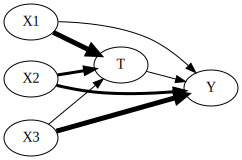

In [60]:
g = gr.Digraph(graph_attr={"rankdir": "LR"})


g.edge("X1", "T", penwidth="5"),
g.edge("X2", "T", penwidth="3"),
g.edge("X3", "T", penwidth="1"),

g.edge("X1", "Y", penwidth="1"),
g.edge("X2", "Y", penwidth="3"),
g.edge("X3", "Y", penwidth="5"),

g.edge("T", "Y"),

g

In [61]:
np.random.seed(123)

n = 100
(x1, x2, x3) = (np.random.normal(0, 1, n) for _ in range(3))
t = np.random.normal(10*x1 + 5*x2 + x3)

# ate = 0.05
y = np.random.normal(0.05*t + x1 + 5*x2 + 10*x3, 5)
df = pd.DataFrame(dict(y=y, t=t, x1=x1, x2=x2, x3=x3))

smf.ols("y~t+x1+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


In [62]:
smf.ols("y~t+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1889,0.523,0.361,0.719,-0.849,1.227
t,0.1585,0.046,3.410,0.001,0.066,0.251
x2,3.6095,0.582,6.197,0.000,2.453,4.766
x3,10.4549,0.537,19.453,0.000,9.388,11.522


## 4.10 요약


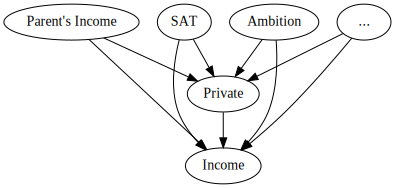

In [63]:
import graphviz as gr

g = gr.Digraph(format="png")

g.edge("Parent's Income", "Private")
g.edge("SAT", "Private")
g.edge("Ambition", "Private")
g.edge("...", "Private")

g.edge("Parent's Income", "Income")
g.edge("SAT", "Income")
g.edge("Ambition", "Income")
g.edge("...", "Income")

g.edge("Private", "Income")

g

#### 참고
* 머신러닝에서의 Bias-Variance Trade-off
    * Bias (편향):
        * 정의: 모델이 데이터의 복잡성을 충분히 반영하지 못해 발생하는 오류입니다. 주로 과소적합(underfitting) 상황에서 나타나며, 데이터의 패턴을 단순화하여 학습하기 때문에 예측 성능이 떨어집니다.
        * 영향: 높은 편향을 가진 모델은 복잡한 관계를 놓치고, 훈련 데이터뿐만 아니라 테스트 데이터에서도 낮은 성능을 보입니다. 이는 지나치게 단순한 모델, 예를 들어 선형 모델에서 자주 발생합니다.
    * Variance (분산):
        * 정의: 모델이 훈련 데이터에 너무 민감하게 반응하여 발생하는 오류입니다. 주로 과적합(overfitting) 상황에서 나타나며, 훈련 데이터의 노이즈까지 학습하기 때문에 새로운 데이터에 대한 일반화 능력이 떨어집니다.
        * 영향: 높은 분산을 가진 모델은 훈련 데이터에서 매우 높은 성능을 보이지만, 테스트 데이터에서는 성능이 급격히 떨어질 수 있습니다. 주로 복잡한 모델에서 발생합니다.

    * Trade-off:
        * 정의: 편향과 분산은 서로 상충하는 관계입니다. 복잡도를 증가시켜 편향을 낮추면 분산이 증가하고, 복잡도를 감소시켜 분산을 줄이면 편향이 증가하는 경향이 있습니다.
        * 목표: 적절한 수준의 모델 복잡도를 찾아 편향과 분산을 균형 있게 조정하는 것이 중요합니다. 이를 통해 최적의 예측 성능을 얻을 수 있습니다.
----
* 인과추론에서의 Bias-Variance Trade-off
    * Bias (편향):
        * 정의: 인과 추론에서 편향은 인과적 관계를 잘못 모델링하거나 중요한 변수나 메커니즘을 놓쳤을 때 발생합니다. 잘못된 모델이나 가정은 결과에 편향된 추정치를 초래합니다.
        * 예시: 혼란 변수(Confounding Variables)를 통제하지 않으면, 변수 간의 인과 관계를 정확하게 추정하지 못해 편향된 결과가 나올 수 있습니다.

    * Variance (분산):
        * 정의: 인과 추론에서 분산은 추정된 인과적 효과가 표본의 변화에 따라 크게 달라지는 경우를 의미합니다. 작은 샘플 크기나 불안정한 모델링 방법은 추정의 불확실성을 높입니다.
        * 영향: 표본 크기가 작거나 변동성이 큰 데이터에서 인과적 추론을 하면, 결과가 불안정하여 동일한 현상에 대한 다른 데이터 셋에서 서로 다른 추정치를 도출할 가능성이 큽니다.

    * Trade-off:
        * 정의: 인과 추론에서도 모델 복잡도를 높이면 더 많은 변수를 통제하게 되어 편향이 줄어들 수 있지만, 동시에 분산은 증가할 수 있습니다. 반대로, 단순한 모델을 사용하면 분산은 줄어들지만 중요한 변수를 통제하지 못해 편향된 결과를 초래할 수 있습니다.
        * 목표: 편향과 분산 간의 적절한 균형을 맞춰 신뢰할 수 있는 인과적 추론을 하는 것이 중요합니다. 특히, 데이터의 크기와 모델의 복잡성을 고려해 최적의 모델을 선택해야 합니다.
----
* 일반화와 인과추론의 목표
    * 머신러닝에서는 모델이 훈련 데이터에서 학습한 패턴을 새로운 데이터에 일반화하는 것이 목표입니다.
    * 인과추론에서는 특정 데이터에서 도출한 인과 관계가 다른 상황이나 모집단에도 일반화될 수 있도록 모델을 구성하는 것이 목표입니다.
    * 이러한 일반화 능력은 두 분야에서 중요한 공통점입니다. 머신러닝에서는 새로운 데이터에서도 성능이 유지되는 모델을, 인과추론에서는 특정 데이터셋에서 도출한 인과적 관계가 다른 환경에서도 유효한지 검증할 수 있는 모델을 목표로 한다는 점에서, 적절한 복잡성 조정과 모델의 일반화 능력이라는 공통된 과제가 있습니다.